In [448]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn import datasets, svm
from sklearn.kernel_approximation import Nystroem
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from math import sqrt
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

plt.style.use('bmh')
df = pd.read_csv('insurance.csv')

# Exploration du dataset

## Valeurs nulles

In [449]:
#Check empty values
print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


On voit qu'aucune donnée n'est manquante dans le jeu de données.
Il nous faudra voir si toutes les données sont pertinentes, mais pour le moment, nous n'avons pas à en supprimer.

## Cast des données de certaines colonnes

Afin de pouvoir analyser des données sous formes d'histogrammes, nous allons devoir transformer les données textuelles en int.
Il s'agit de "sex", "smoker" et "region". 
sex_male : male -> 1 et female -> 0
smoker_yes : no -> 0 et yes -> 1
region => southwest -> 0, southeast -> 1, northwest -> 2, northeast -> 3

In [ ]:
#Parse string to int
df['sex'] = df['sex'].replace({'male': 1, 'female': 0})
df['smoker'] = df['smoker'].replace({'yes': 1, 'no': 0})
df['region'] = df['region'].replace({'southwest': 0, 'southeast': 1, 'northwest':2, 'northeast':3})

## Boxplots

TypeError: Could not convert malemalemalemalefemalefemalefemalemalefemalemalemalefemalemalefemalemalemalefemalefemalemalemalefemalefemalefemalemalefemalefemalemalemalefemalemalefemalefemalemalefemalemalemalefemalefemalefemalefemalefemalefemalefemalefemalemalemalemalefemalefemalefemalemalefemalemalefemalemalemalemalefemalemalefemalefemalemalefemalefemalefemalefemalefemalefemalefemalemalefemalefemalemalefemalemalefemalefemalefemalemalemalemalefemalemalefemalemalemalemalefemalefemalemalemalefemalefemalefemalefemalemalefemalefemalefemalemalefemalefemalemalemalefemalefemalemalemalemalefemalefemalefemalemalemalemalefemalefemalemalefemalemalefemalemalemalefemalefemalefemalemalemalemalemalefemalefemalemalemalefemalefemalemalefemalemalefemalemalefemalefemalefemalefemalemalefemalemalefemalemalemalefemalefemalefemalefemalefemalefemalefemalemalefemalemalefemalemalemalemalemalefemalefemalefemalefemalemalefemalefemalefemalefemalemalemalemalefemalefemalemalefemalefemalefemalemalemalefemalemalemalefemalefemalemalemalefemalemalemalemalemalefemalefemalemalefemalefemalefemalemalemalemalemalemalemalefemalemalefemalemalefemalemalefemalefemalemalefemalefemalemalefemalemalefemalemalemalefemalemalefemalefemalefemalemalefemalefemalemalefemalemalefemalemalemalemalemalefemalemalemalefemalemalemalemalefemalemalefemalefemalefemalemalemalemalefemalefemalemalefemalemalefemalefemalemalemalefemalemalefemalefemalefemalemalefemalemalemalemalemalefemalefemalemalefemalefemalefemalefemalefemalemalemalefemalefemalefemalemalefemalemalemalefemalemalemalefemalemalefemalefemalemalefemalemalemalefemalemalefemalemalemalefemalefemalemalefemalemalemalefemalefemalefemalemalemalemalemalefemalefemalemalemalemalemalemalefemalefemalefemalefemalemalefemalemalefemalemalemalemalemalefemalemalefemalemalefemalefemalemalefemalefemalemalemalemalemalemalemalemalefemalefemalemalefemalefemalefemalemalemalefemalefemalefemalefemalemalefemalefemalefemalemalemalemalemalemalefemalefemalemalefemalefemalemalemalefemalefemalefemalemalemalefemalemalefemalefemalemalefemalemalemalemalefemalefemalemalemalemalemalemalemalemalefemalemalefemalefemalefemalefemalefemalefemalefemalemalemalefemalemalemalemalemalefemalefemalefemalemalefemalefemalefemalemalemalefemalefemalemalefemalemalefemalefemalemalemalemalemalefemalefemalemalemalefemalefemalefemalemalefemalefemalefemalefemalefemalefemalefemalemalemalefemalemalemalemalefemalemalefemalemalefemalefemalefemalemalemalemalefemalefemalefemalemalefemalefemalemalefemalefemalefemalefemalemalefemalefemalefemalefemalefemalefemalefemalemalefemalemalefemalemalemalemalemalemalefemalemalemalemalefemalefemalemalemalemalefemalemalemalemalefemalemalefemalefemalefemalefemalefemalefemalefemalemalefemalefemalemalefemalefemalemalemalefemalemalefemalemalefemalemalefemalemalefemalefemalemalemalefemalemalemalemalefemalemalemalemalemalefemalefemalefemalemalefemalefemalefemalemalefemalefemalefemalemalefemalefemalemalefemalefemalemalefemalemalefemalemalefemalefemalefemalemalemalemalefemalemalefemalefemalemalefemalefemalefemalefemalemalemalefemalemalefemalemalemalefemalemalemalemalefemalemalemalefemalemalefemalemalemalefemalefemalemalefemalefemalefemalemalefemalefemalemalemalemalemalemalemalemalemalefemalefemalemalemalemalefemalefemalemalefemalefemalemalefemalefemalefemalefemalemalemalefemalefemalefemalemalemalefemalefemalemalemalemalefemalefemalemalemalemalefemalefemalemalefemalemalemalefemalefemalemalemalemalemalefemalefemalefemalemalemalemalefemalemalefemalemalemalefemalefemalefemalemalefemalefemalefemalemalemalemalemalemalefemalemalefemalemalemalemalefemalefemalemalemalefemalemalemalefemalemalefemalemalemalefemalemalemalefemalemalefemalefemalemalemalemalefemalefemalemalefemalemalemalefemalefemalemalefemalefemalefemalefemalefemalemalemalemalemalefemalefemalefemalemalemalefemalemalefemalemalefemalemalefemalemalemalemalefemalefemalemalemalefemalemalemalemalefemalemalemalemalefemalefemalefemalemalemalemalemalemalefemalefemalefemalefemalefemalemalemalemalefemalefemalemalemalefemalemalefemalemalefemalemalefemalefemalefemalemalefemalefemalefemalefemalefemalemalemalemalemalemalemalemalefemalefemalemalefemalemalefemalefemalefemalefemalemalemalefemalefemalemalemalefemalefemalemalefemalemalemalemalefemalemalefemalefemalefemalemalemalefemalemalefemalefemalefemalemalemalemalemalefemalefemalemalemalemalefemalemalemalefemalefemalefemalefemalemalemalemalemalemalemalefemalemalemalemalemalefemalemalefemalefemalemalefemalefemalemalemalemalemalefemalefemalefemalemalemalefemalefemalemalemalemalefemalemalefemalefemalemalefemalemalefemalefemalemalemalefemalemalefemalefemalefemalemalemalefemalefemalemalemalemalefemalemalemalefemalefemalefemalefemalefemalefemalefemalefemalefemalemalemalefemalefemalefemalemalefemalemalefemalefemalemalemalefemalefemalefemalefemalefemalefemalefemalemalefemalefemalefemalefemalefemalefemalefemalefemalemalemalefemalemalemalemalemalemalefemalemalemalemalemalefemalefemalemalemalemalefemalefemalemalemalemalefemalemalemalemalemalefemalemalefemalemalefemalefemalemalefemalefemalefemalemalemalefemalemalefemalemalefemalefemalefemalefemalefemalemalefemalefemalemalefemalefemalefemalefemalefemalemalemalefemalemalemalemalefemalefemalefemalefemalemalefemalefemalefemalemalefemalemalemalemalemalemalefemalemalefemalefemalefemalemalemalefemalemalemalefemalemalemalefemalemalemalemalemalefemalemalefemalemalefemalefemalefemalemalefemalefemalefemale to numeric

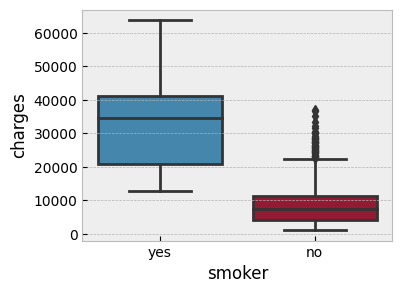

In [450]:
plt.figure("Smoker vs charges", figsize=(4, 3))
sns.boxplot(x='smoker', y='charges', data=df)
df.groupby('smoker').agg(['mean','min','max'])['charges']

La médiane des charges des non-fumeurs est très largement inférieure à celles des fumeurs.
Aussi, la valeur maximimale de charges payées par un fumeur est de 63770€ contrairement aux non fumeurs, situées à un peu moins de 40000€. 

Ce boxplot nous indique donc que les deux groupes ont des distributions de charges différentes, sans pour autant impliquer que le tabagisme est la cause de cette différence. En effet, il est possible que d'autres facteurs tels que l'âge, le sexe, le régime alimentaire ou les antécédents médicaux puissent influencer les niveaux de charges dans les deux groupes.

<Axes: xlabel='region', ylabel='charges'>

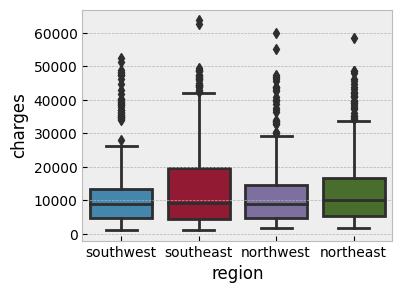

In [ ]:
plt.figure("Region vs charges", figsize=(4, 3))
sns.boxplot(x='region', y='charges', data=df)
df.groupby('region').agg(['mean','min','max'])['charges']

On peut remarquer que la médiane de charges médicales payées est égale pour tous les boxplots représentant chaque région.

<Axes: xlabel='sex', ylabel='charges'>

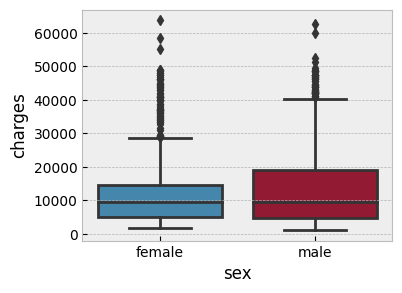

In [ ]:
plt.figure("Sex vs charges", figsize=(4, 3))
sns.boxplot(x='sex', y='charges', data=df)
df.groupby('sex').agg(['mean','min','max'])['charges']

On peut remarquer que la médiane de charges médicales payées est égale pour les boxplots de sexe féminin et masculin.

In [ ]:
plt.figure("Children vs charges", figsize=(4, 3))
sns.boxplot(x='children', y='charges', data=df)
df.groupby('children').agg(['mean','min','max'])['charges']

A interpreter

In [ ]:
plt.figure("BMI vs charges", figsize=(4, 3))
sns.boxplot(x='bmi', y='charges', data=df)
df.groupby('bmi').agg(['mean','min','max'])['charges']

A interpreter

In [ ]:
#Scatter Matrix plot
#sns.pairplot(df)

A interpréter

## Pairplots

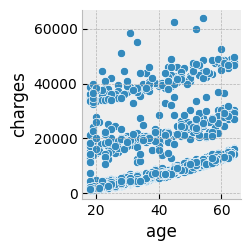

In [ ]:
#Scatter plots of charges vs all (prettier to see than the matrix)
sns.pairplot(data=df, x_vars=['age'], y_vars=['charges'])


A interpréter

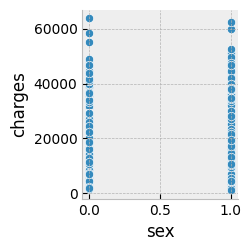

In [ ]:
sns.pairplot(data=df, x_vars=['sex'], y_vars=['charges'])

A interpréter

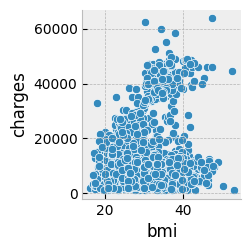

In [ ]:
sns.pairplot(data=df, x_vars=['bmi'], y_vars=['charges'])

A interpréter

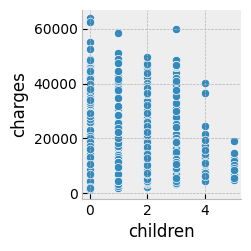

In [ ]:
sns.pairplot(data=df, x_vars=['children'], y_vars=['charges'])

A interpréter

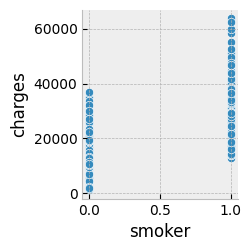

In [ ]:
sns.pairplot(data=df, x_vars=['smoker'], y_vars=['charges'])

A interpréter

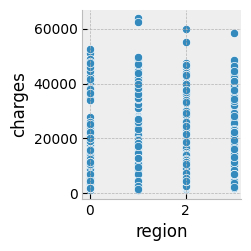

In [ ]:
sns.pairplot(data=df, x_vars=['region'], y_vars=['charges'])

A interpréter

## Corrélations


There are 4 lowly correlated values and 1 highly correlated value with Charges:
smoker      0.787251
age         0.299008
bmi         0.198341
children    0.067998
sex         0.057292
region      0.006208
Name: charges, dtype: float64


<Axes: >

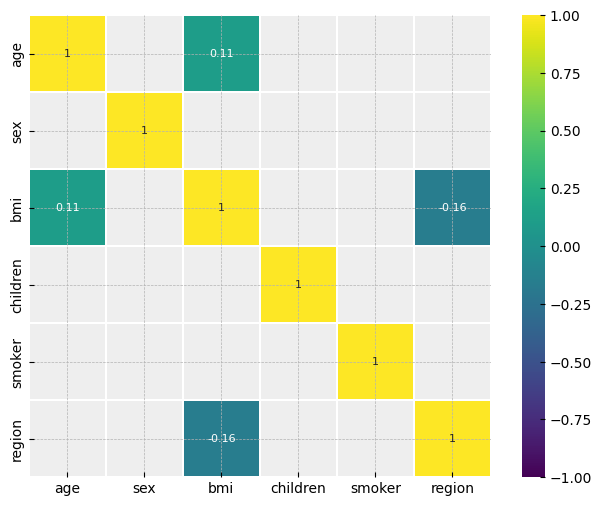

In [ ]:
dfcorr = df.corr()['charges'][:-1]
golden_features_list = dfcorr.sort_values(ascending=False)
print(
    "\nThere are {} lowly correlated values and 1 highly correlated value with Charges:\n{}"
    .format(len(golden_features_list) - 2, golden_features_list))

corr = df.drop('charges',
               axis=1).corr()  # We already examined Charges correlations
plt.figure(figsize=(8, 6))

sns.heatmap(corr[(corr >= 0.1) | (corr <= -0.1)],
            cmap='viridis',
            vmax=1.0,
            vmin=-1.0,
            linewidths=0.1,
            annot=True,
            annot_kws={"size": 8},
            square=True)

A interpréter
//Pas de corrélation entre les variables ??

Conclusion : si on enlève des données inutiles ou pas ?

## Split du jeu de données en jeu d'entraînement et de test

Nous allons débuter par diviser notre jeu de données en un jeu d'entraînement et un jeu de tests
30% des données seront de test, et 70% seront d'entraînement.
Le random_state = 42 nous garantie que les mêmes jeux de données sont obtenues à chaque exécution du code. C'est particulièrement important pour la reproductibilité des résultats dans les expériences de machine learning. Nous l'avons fixé arbitrairement à 42.

In [ ]:
X = df.drop(['charges'], axis=1)
y = df['charges']
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)

X_train: un DataFrame contenant les données d'entraînement pour les variables explicatives (toutes les colonnes de 'df' à l'exception de 'charges').
y_train: une série contenant les données d'entraînement pour la variable cible (la colonne 'charges').
X_test: un DataFrame contenant les données de test pour les variables explicatives.
y_test: une série contenant les données de test pour la variable cible.

Nous allons maintenant entraîner un modèle à trouver un lien entre y_train (sorites) et X_train (entrées)

# Entraînement

## Modèle de régression linéaire

Nous débutons par le modèle de régression linéaire car c'est l'une des méthodes de régression les plus simples. L'un de ses principaux avantages est la facilité d'interprétation des résultats.

### Construction du modèle

In [ ]:
# Création d'un objet modeleRegressionLineaire de régression linéaire
modeleRegressionLineaire = LinearRegression()

# Entraînement du modèle sur les données d'entraînement
#Pour obtenir les meilleures pondérations, une minimisation de la somme des carrés des résidus (SSR) sera cherchée, pour toutes les observations.
# Il s'agit de la méthode des moindres carrés ordinaires.
modeleRegressionLineaire.fit(X_train, y_train)

LinearRegression()

### Ce que dit le modèle


In [ ]:
for idx, col_name in enumerate(X_train.columns):
    print("Linear regression model coefficient for {} is {}".format(
        col_name, modeleRegressionLineaire.coef_[idx]))

Linear regression model coefficient for age is 261.62568984274697
Linear regression model coefficient for sex is 109.64719595060546
Linear regression model coefficient for bmi is 344.54483065603574
Linear regression model coefficient for children is 424.37016595763544
Linear regression model coefficient for smoker is 23620.802521481754
Linear regression model coefficient for region is 326.4626252721868


Les variables age, sex, bmi et region ont toutes un effet positif sur la variable cible Charges, et le nombre d'enfants ainsi que le tabagisme ont un effet encore plus positif. Il convient également de noter que le coefficient de la variable smoker est beaucoup plus élevé que celui des autres variables, ce qui indique que le tabagisme a un effet beaucoup plus important sur les coûts de santé que les autres variables.

In [ ]:
intercept = modeleRegressionLineaire.intercept_
print("The intercept for linear regression model is {}".format(intercept))

The intercept for linear regression model is -13343.77919809582


Ce résultat indique que lorsque toutes les variables explicatives (âge, sexe, IMC, nombre d'enfants, tabagisme et région) sont nulles, la charge moyenne pour une personne est d'environ -13252,02 euros. Ce n'est jamais le cas, donc ce renseignement ne nous semble pas pertinent.

### Evaluation de la qualité du modèle

Nous commencons par calculer le coefficient de détermination R² du modèle.
Il indique dans quelle mesure la variation de 𝑦 peut être expliquée par la dépendance à X, en utilisant le modèle de régression en question. Un 𝑅² plus grand indique une meilleure adéquation et signifie que le modèle peut mieux expliquer la variation de la production avec différentes entrées. Par exemple, un 𝑅²égal à 1 corresponds à SSR = 0. Il s'agit d'un ajustement parfait, puisque les valeurs des réponses prédites et réelles s'accordent parfaitement entre elles.

In [ ]:
score = modeleRegressionLineaire.score(X_test, y_test)
print("Score du modèle : ", score)

Score du modèle :  0.7694415927057693


Un R² de 0,76 indique que le modèle de régression linéaire est capable d'expliquer 76% de la variance de la variable cible en utilisant les variables explicatives. Le modèle est donc relativement performant.
En revanche, R² ne suffit pas à évaluer la qualité du modèle.

### Prédictions du modèle

In [ ]:
predictionChargesRegressionLineaires = modeleRegressionLineaire.predict(X_test)

Nous allons maintenant pouvoir comparer predictionChargesRegressionLineaires et y_test

#### Linéarité

Tout d'abord, nous allons tracer un nuage de points qui représente la relation entre les valeurs réelles et les valeurs prédites de la variable cible (Charges).

Text(0, 0.5, 'Valeurs prédites par le modèle')

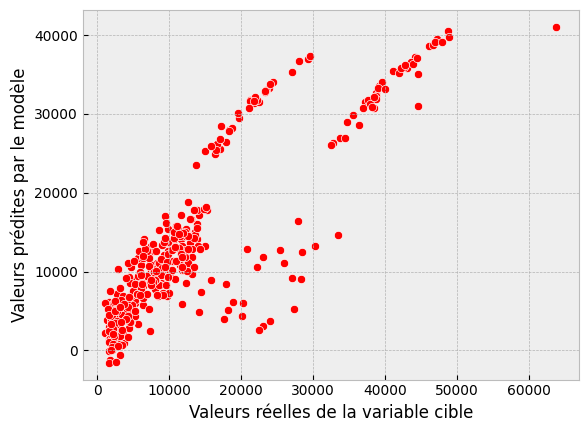

In [ ]:
sns.scatterplot(x=y_test, y=predictionChargesRegressionLineaires, color='r')
plt.xlabel("Valeurs réelles de la variable cible")
plt.ylabel("Valeurs prédites par le modèle")

A interpréter

#### Normalité et moyenne des résidus

Nous allons visualiser la distribution des erreurs de prédiction de notre modèle de régression linéaire, c'est-à-dire la différence entre les valeurs réelles de la variable cible (y_test) et les valeurs prédites par le modèle (predictionChargesRegressionLineaires).
Si l'histogramme des écarts obtenus est centré autour de zéro et suit une distribution normale, cela signifie que les erreurs de prédiction sont faibles et que notre modèle est capable de faire des prédictions précises. En revanche, si l'histogramme présente une distribution asymétrique ou est centré autour d'une valeur non nulle, cela peut indiquer la présence de biais ou d'erreurs systématiques dans notre modèle.

<Axes: xlabel='charges', ylabel='Count'>

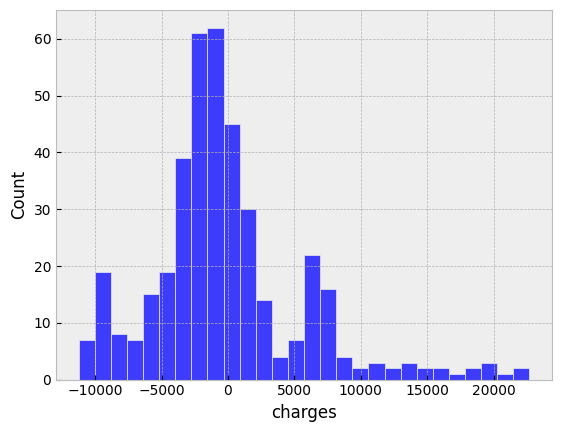

In [ ]:
sns.histplot((y_test - predictionChargesRegressionLineaires),color='b')

A interpréter

#### Normalité multivariée

Text(0.5, 1.0, 'Check for Multivariate Normality: \nQ-Q Plot')

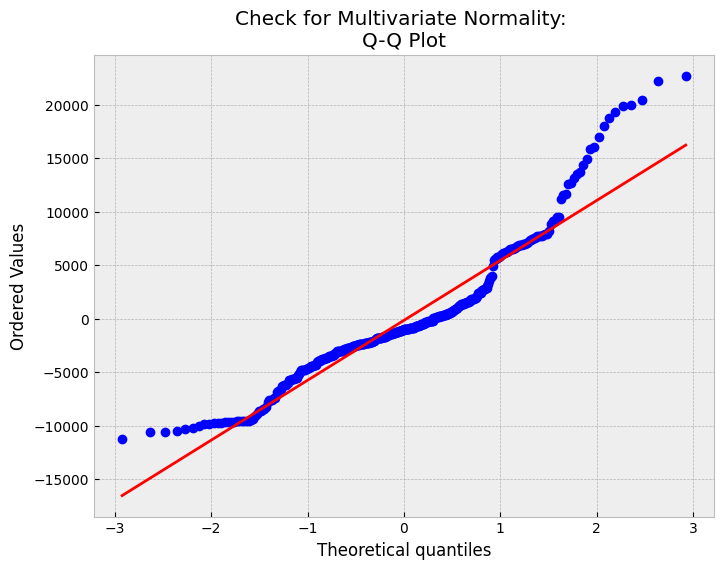

In [ ]:
fig, ax = plt.subplots(figsize=(8, 6))

# Tracer le graphique de probabilité normal
_, (_, _, r) = sp.stats.probplot((y_test - predictionChargesRegressionLineaires), fit=True, plot=ax)
ax.set_title('Check for Multivariate Normality: \nQ-Q Plot')

A interpréter

#### Homoscédasticité

<Axes: ylabel='charges'>

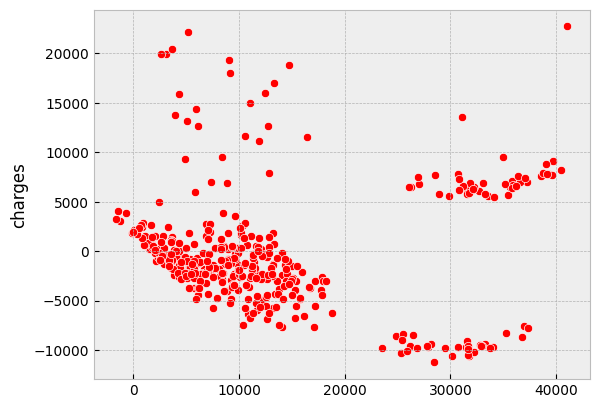

In [ ]:
sns.scatterplot(y = (y_test - predictionChargesRegressionLineaires), x= predictionChargesRegressionLineaires, color='r') 

A interpréter

## Modèle de régression de Kernel Ridge

### Construction du modèle


In [ ]:
k = 5

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=123)

kr_param_grid = {"alpha": [100, 50, 25, 10, 5, 1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5],
                "kernel": ['linear','rbf','poly'],
                "gamma": [1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]}

# # ridge works best
kr = GridSearchCV(KernelRidge(), cv=k, param_grid=kr_param_grid)
kr.fit(X_train, np.asarray(y_train).ravel())

train_rmse = sqrt(mean_squared_error(y_train, kr.predict(X_train)))
test_rmse = sqrt(mean_squared_error(y_test, kr.predict(X_test)))

print(train_rmse)
print(test_rmse)

C:\Users\33660\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=6.85809e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
C:\Users\33660\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=6.11025e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
C:\Users\33660\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_ridge.py:253: LinAlgWarning: Ill-conditioned matrix (rcond=7.07648e-17): result may not be accurate.
  dual_coef = linalg.solve(K, y, assume_a="pos", overwrite_a=False)
C:\Users\3

4844.613870480204
4744.381415597341


A interpreter

In [ ]:
print(kr.best_params_)

{'alpha': 1e-05, 'gamma': 0.0001, 'kernel': 'rbf'}


A interpréter

In [ ]:
kf = KFold(n_splits=k, shuffle=True, random_state=42)
modeleRegressionKernelRidge = KernelRidge(alpha=kr.best_params_['alpha'], kernel=kr.best_params_['kernel'], gamma=kr.best_params_['gamma'])

ValueError: Setting a random_state has no effect since shuffle is False. You should leave random_state to its default (None), or set shuffle=True.

### Ce que dit le modèle


In [ ]:
coef = modeleRegressionKernelRidge.dual_coef_


### Evaluation de la qualité du modèle

### Prédictions du modèle

## Nouveau modèle

Expliquer pourquoi Kernel regression

### Construction du modèle

### Ce que dit le modèle

### Evaluation de la qualité du modèle